<a href="https://colab.research.google.com/github/jhbale11/Object_Detection/blob/main/Object_Detection_with_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 30kB/s 
     |████████████████████████████████| 460kB 38.4MB/s 
     |████████████████████████████████| 3.0MB 28.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2648, done.
remote: Counting objects: 100% (2648/2648), done.
remote: Compressing objects: 100% (2194/2194), done.
remote: Total 2648 (delta 670), reused 1296 (delta 421), pack-reused 0
Receiving objects: 100% (2648/2648), 32.61 MiB | 28.69 MiB/s, done.
Resolving deltas: 100% (670/670), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1648944 sha256=73f9927e7a740df02260917eceb48436cc1b58a0aedaa4b16183c3d9368945b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xwgqzf30/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=6d588964799f586855323929cfb81d7d0bd466885517b126cccf902ffe81ffc3
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=1bc1dfe7761c535f80972e7a2239e2ae3bac847aecf0f2a993af201d29cd2bb2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=1ddd276e44228e5ba6304e51e5e9a6b203a564fe741a5921b0d5

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [4]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

# COCO DATASET setting

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [6]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz
!mv efficientdet_d5_coco17_tpu-32/ models/research/object_detection/test_data/

--2021-05-13 01:59:03--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.139.128, 2607:f8b0:400c:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.139.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256286417 (244M) [application/x-tar]
Saving to: ‘efficientdet_d5_coco17_tpu-32.tar.gz’

efficientdet_d5_coc 100%[===================>] 244.41M   132MB/s    in 1.9s    

2021-05-13 01:59:05 (132 MB/s) - ‘efficientdet_d5_coco17_tpu-32.tar.gz’ saved [256286417/256286417]



In [7]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('models/research/object_detection/test_data/efficientdet_d5_coco17_tpu-32/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 65.19626641273499s


Elapsed time: 14.874622642993927 second per image


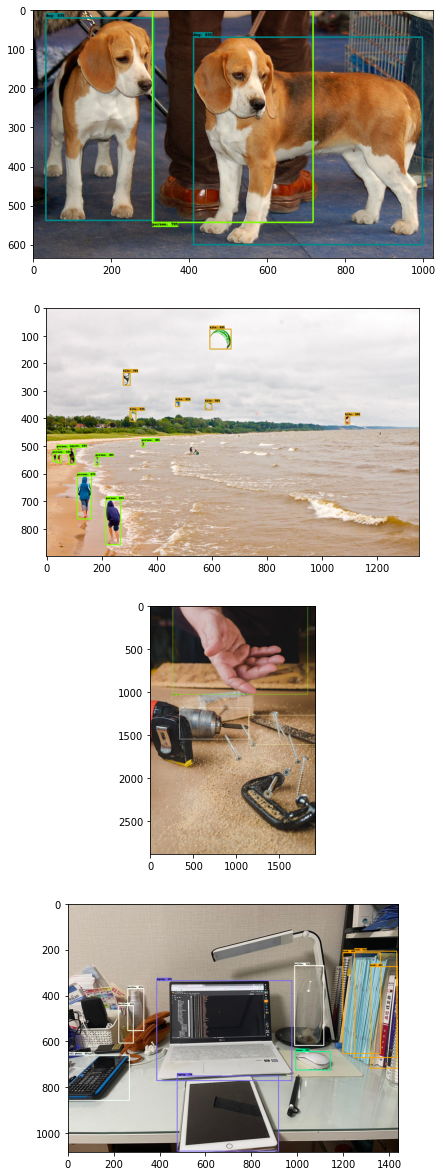

In [12]:
import time

image_dir = 'models/research/object_detection/test_images'

elapsed = []
for i in range(4):
  image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  plt.subplot(4, 1, i+1)
  plt.imshow(image_np_with_detections)
  
mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')